Semantic Segmentation 
============

In this exercise you are going to work on a computer vision task called semantic segmentation. In comparison to image classification the goal is not to classify an entire image but each of its pixels separately. This implies that the  output of the network is not a single scalar but a segmentation with the same shape as the input image. Think about why you should rather use convolutional than fully-connected layers for this task!

Since we already introduced the basics of PyTorch and how to train a NN we leave the model design and architecture as well as the training up to you. We only provide you with the train, validation and test dataset and recommend you to look for inspirational, existing PyTorch implementations. Due to the fairly small size of the segmentation dataset you should not train a model from scratch but consider to (at least partially) finetune weights of an already exsisting model.

The infamous  [Fully Convolutional Networks for Semantic Segmentation](https://people.eecs.berkeley.edu/~jonlong/long_shelhamer_fcn.pdf) paper might help you with finding a suitable segmentation model and architecture.

<img src="https://camo.githubusercontent.com/d10b897e15344334e449104a824aff6c29125dc2/687474703a2f2f63616c76696e2e696e662e65642e61632e756b2f77702d636f6e74656e742f75706c6f6164732f646174612f636f636f7374756666646174617365742f636f636f73747566662d6578616d706c65732e706e67">

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable

from dl4cv.classifiers.segmentation_nn import SegmentationNN
from dl4cv.data_utils import SegmentationData, label_img_to_rgb

#torch.set_default_tensor_type('torch.FloatTensor')

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

MSRC-v2 Segmentation Dataset
================

Make yourself familiar with the segmentation dataset and how we implemented the `SegmentationData` class in `dl4cv/data_utils.py`. Furthermore have a look at the labels described in `data/segmentation_data/info.html`. Especially note the label `unlabeled`. Pixels with the label `unlabeled` should neither be considered in your loss nor in the accuracy of your segmentation.

In [2]:
train_data = SegmentationData(image_paths_file='datasets/segmentation_data/train.txt')
val_data = SegmentationData(image_paths_file='datasets/segmentation_data/val.txt')

Train size: 276
Validation size: 59
Img size:  torch.Size([3, 240, 240])
Segmentation size:  torch.Size([240, 240])


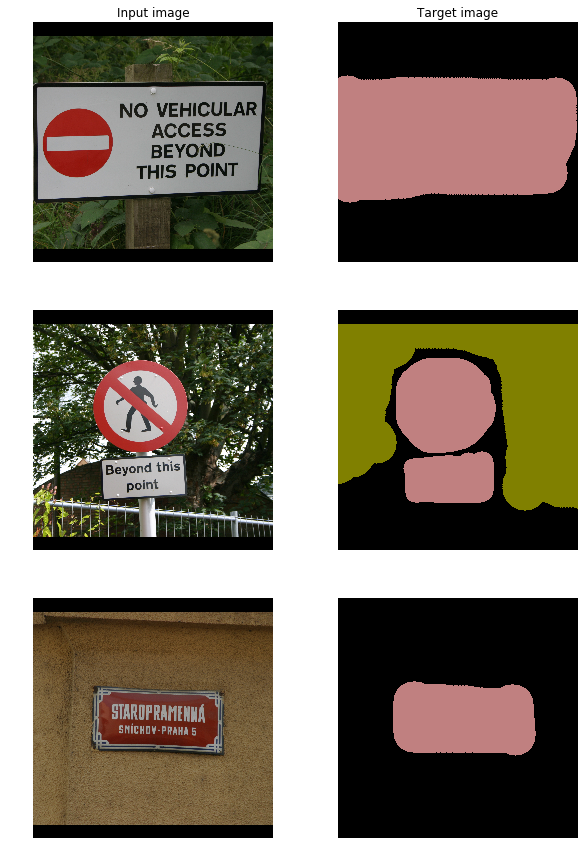

In [3]:
print("Train size: %i" % len(train_data))
print("Validation size: %i" % len(val_data))
print("Img size: ", train_data[0][0].size())
print("Segmentation size: ", train_data[0][1].size())

num_example_imgs = 3
plt.figure(figsize=(10, 5 * num_example_imgs))
for i, (img, target) in enumerate(train_data[:num_example_imgs]):
    # img
    plt.subplot(num_example_imgs, 2, i * 2 + 1)
    plt.imshow(img.numpy().transpose(1,2,0))
    plt.axis('off')
    if i == 0:
        plt.title("Input image")
    
    # target
    plt.subplot(num_example_imgs, 2, i * 2 + 2)
    plt.imshow(label_img_to_rgb(target.numpy()))
    plt.axis('off')
    if i == 0:
        plt.title("Target image")
plt.show()

Design and Train your Network
==========

Implement your network architecture in `dl4cv/classifiers/segmentation_nn.py` and adapt your `Solver` to process segmentation labels. To compensate for the dimension reduction of a typical convolution layer, you should probably include a `nn.Upsample` layer near the end of your network. Also remember to consider finetuning a model instead of training it from scratch.

Up until now we only used the default loss function (`nn.CrossEntropyLoss`) of our `Solver` class. However, in order to ignore the `unlabeled` pixels for the computation of our loss, we have to usw a customized version of the loss for the initializtation of the `Solver` class. The `ignore_index` argument of the loss can be used to filter the `unlabeled` pixels and computes the loss only over remaining pixels.

Step by step:
1. Initialize training and validation data loaders.
2. Design and initialize a convolutional neural network architecture that has input (N, C, H, W) and output (N, num_classes, H, W) and is based on an already pretrained network.
3. Initialize a solver with a loss function that considers the `unlabeled` pixels.
4. Adjust the logging of your solver to account for the `unlabeled` pixels.
5. Train a segmentation model.

In [4]:
from dl4cv.classifiers.segmentation_nn import SegmentationNN
from dl4cv.solver import Solver
import torch.nn.functional as F


########################################################################
#                             YOUR CODE                                #
########################################################################
train_loader = torch.utils.data.DataLoader(train_data, batch_size=10, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=10, shuffle=False, num_workers=4)

model = SegmentationNN()
model

SegmentationNN(
  (vgg_feat): Sequential(
    (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)
    (1

In [5]:
from torch.autograd import Variable

def train(model, train_loader, val_loader, epoch):
    optimizer = torch.optim.SGD(model.parameters(), lr=5e-5, momentum=0.9, dampening=2e-5)
    criterion = torch.nn.CrossEntropyLoss(ignore_index=-1)
    
    for epoch_id in range(epoch):
        train_losses = []
        for i, (inputs, targets) in enumerate(train_loader, 1):
            inputs, targets = Variable(inputs), Variable(targets)
                
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = 0
            for s in range(inputs.size()[0]):
                loss += criterion(outputs[s].view(23, -1).transpose(1, 0), targets[s].view(-1))
            train_losses.append(loss.data[0] / inputs.size()[0])
            loss.backward()
            optimizer.step()
        
        _, preds = torch.max(outputs, 1)
        targets_mask = targets >= 0
        train_acc = np.mean((preds == targets)[targets_mask].data.cpu().numpy())
        print('[Epoch %d/%d] TRAIN acc/loss: %.3f/%.3f' % (epoch_id + 1,
                                                           epoch,
                                                           train_acc,
                                                           train_losses[-1]))

In [6]:
train(model, train_loader, val_loader, 15)

Process Process-1:
Process Process-2:
Process Process-4:
Process Process-3:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/bpadalkar/Desktop/TUM/dl4cv/dl4cv/.venv/lib/py

KeyboardInterrupt: 

# Test your Model

Your model should easily yield a pixel accuracy of more than 60%.

In [7]:
test_data = SegmentationData(image_paths_file='datasets/segmentation_data_test/test.txt')
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=1,
                                          shuffle=False,
                                          num_workers=1)

test_scores = []
model.eval()
for inputs, targets in test_loader:
    inputs, targets = Variable(inputs), Variable(targets)
    if model.is_cuda:
        inputs, targets = inputs.cuda(), targets.cuda()
    
    outputs = model.forward(inputs)
    _, preds = torch.max(outputs, 1)
    targets_mask = targets >= 0
    test_scores.append(np.mean((preds == targets)[targets_mask].data.cpu().numpy()))
    
model.train()
np.mean(test_scores)

0.031233655222612029

# Visualization

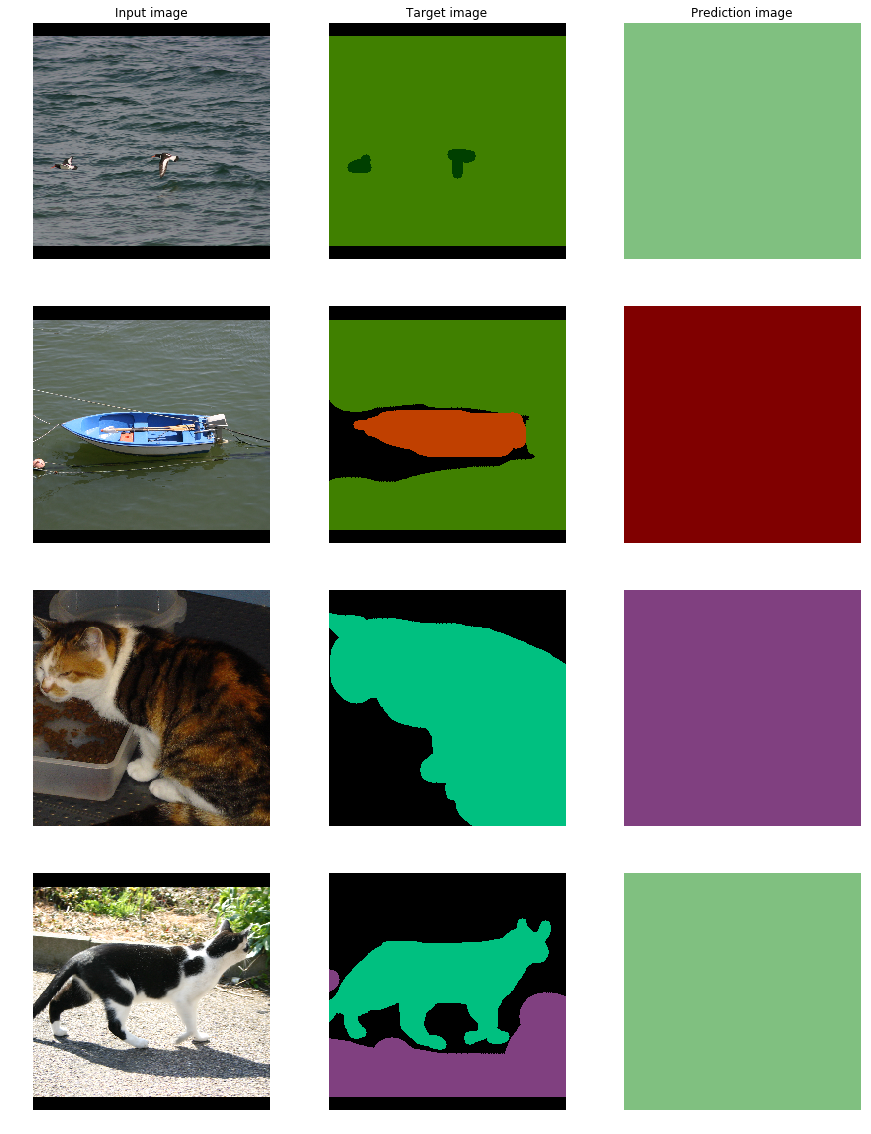

In [8]:
num_example_imgs = 4
plt.figure(figsize=(15, 5 * num_example_imgs))
for i, (img, target) in enumerate(test_data[:num_example_imgs]):
    inputs = img.unsqueeze(0)
    inputs = Variable(inputs)
    if model.is_cuda:
        inputs = inputs.cuda()
    
    outputs = model.forward(inputs)
    _, preds = torch.max(outputs, 1)
    pred = preds[0].data.cpu()
    
    img, target, pred = img.numpy(), target.numpy(), pred.numpy()
    
    # img
    plt.subplot(num_example_imgs, 3, i * 3 + 1)
    plt.axis('off')
    plt.imshow(img.transpose(1,2,0))
    if i == 0:
        plt.title("Input image")
    
    # target
    plt.subplot(num_example_imgs, 3, i * 3 + 2)
    plt.axis('off')
    plt.imshow(label_img_to_rgb(target))
    if i == 0:
        plt.title("Target image")

    # pred
    plt.subplot(num_example_imgs, 3, i * 3 + 3)
    plt.axis('off')
    plt.imshow(label_img_to_rgb(pred))
    if i == 0:
        plt.title("Prediction image")
    
plt.show()

## Visualize Filter Weights
You can visualize the convolutional filters of the very first layer by running the following cell. The kernels should exhibit clear structures of differently oriented edges, corners and circles.

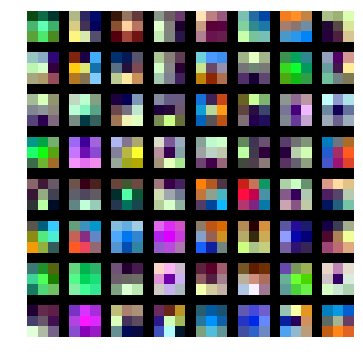

In [9]:
from dl4cv.vis_utils import visualize_grid

# first (next) parameter should be convolutional
conv_params = next(model.parameters()).data.cpu().numpy()
grid = visualize_grid(conv_params.transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(6, 6)
plt.show()

## Save the Model

When you are satisfied with your training, save the model for submission.

In [10]:
model.save("models/segmentation_nn.model")

Saving model... models/segmentation_nn.model


## Possible Next Steps

1. Implement and integrate a task specific metric such as [Intersection over Union (IoU)](http://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/)
2. Hyperparameter optimization
3. Data augmentation ([PyTorch tutorial](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html))

## Scoring function
We will score the model you have just saved based on the classification accuracy on our test dataset. The scoring function should represent the difficulty of obtaining a good test accuracy and should therefore give 0 points for worse results than random guessing, should be linear in a first regime and exponential beyond that. The onset of exponential growth depends on the problem. In that region you get twice as many points for an additional 10% accuracy.

For this problem we specifically use the following scoring function:
    $$f(x) = \left\{
	\begin{array}{ll}
		0  & \mbox{if } x \leq 0.1 \\
		100x & \mbox{if } 0.1 < x \leq 0.5 \\
        \left(\frac{50}{\exp(0.5 \ln(2)/0.1)}\right) \exp(x \ln(2)/0.1) & \mbox{if } 0.5 < x \leq 1
	\end{array}
\right.$$

The function can be plotted in the following cell.

In [ ]:
from dl4cv.data_utils import scoring_function

x = np.linspace(0, 1, num=1000)
plt.plot(x, scoring_function(x, lin_exp_boundary=0.5, doubling_rate=0.1))
plt.title('Scoring Function')
plt.xlabel('Test Accuracy')
plt.ylabel('Score')
plt.show()